CED:solidWhiteRight


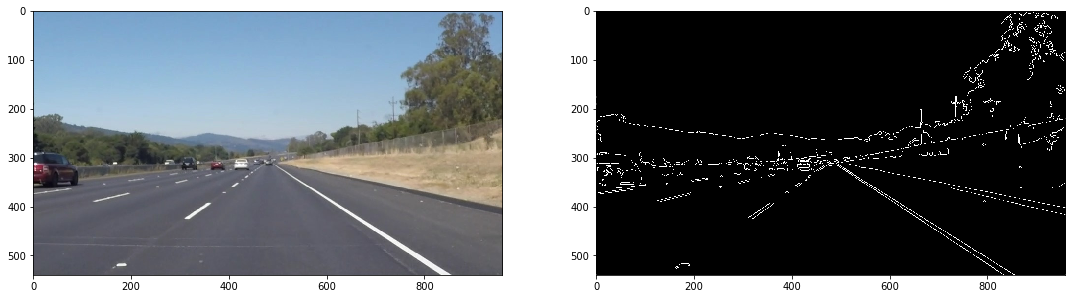

In [2]:
# CANNY EDGE DETECTION

#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import itertools as it

# Read in the image and convert to grayscale
image = mpimg.imread('solidWhiteRight.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 3
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(edges, cmap='Greys_r')

print('CED:solidWhiteRight')
plt.show()


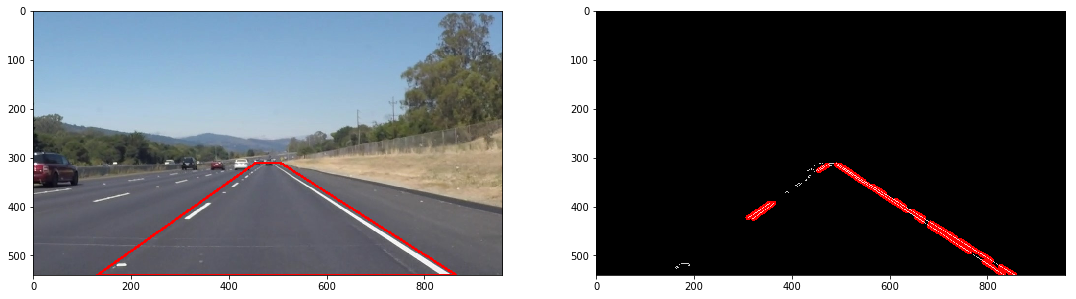

In [103]:
# MASKING AND P-HOUGH TRANSFORM TO GET LINE AND LINE-COORDINATES

# make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
region_select = np.copy(image)

# Define a region of interest 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing
left_bottom = (130, 540)
left_top = (455, 310)
right_top = (505, 310)
right_bottom = (865, 540)

# Draw a line with thickness of 4 px
region_select = cv2.line(region_select,left_bottom,left_top,(255,0,0),4)
region_select = cv2.line(region_select,left_top,right_top,(255,0,0),4)
region_select = cv2.line(region_select,right_top,right_bottom,(255,0,0),4)
region_select = cv2.line(region_select,right_bottom,left_bottom,(255,0,0),4)


# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[left_bottom,left_top,right_top,right_bottom]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)


# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 10
max_line_gap = 1
line_image = np.copy(image)*0 #creating a blank to draw lines on

# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on the blank
m_parm = []
n_parm = []
x1_parm = []
y1_parm = []
x2_parm = []
y2_parm = []

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        m_parm.append((y2-y1)/(x2-x1))
        x1_parm.append(x1)
        y1_parm.append(y1)
        x2_parm.append(x2)
        y2_parm.append(y2)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

# Display the image
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(region_select, cmap='Greys_r')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(combo)

plt.show()



[0.69999999999999996, 0.55555555555555558, 0.58695652173913049, 0.6071428571428571, 0.65277777777777779, 0.68421052631578949, 0.64000000000000001, 0.66666666666666663, 0.625, 0.65714285714285714, 0.59999999999999998, 0.59999999999999998, 0.7142857142857143, 0.69999999999999996, 0.65000000000000002, 0.5, 0.75, 0.5, 0.61111111111111116, 0.70588235294117652, 0.59999999999999998]


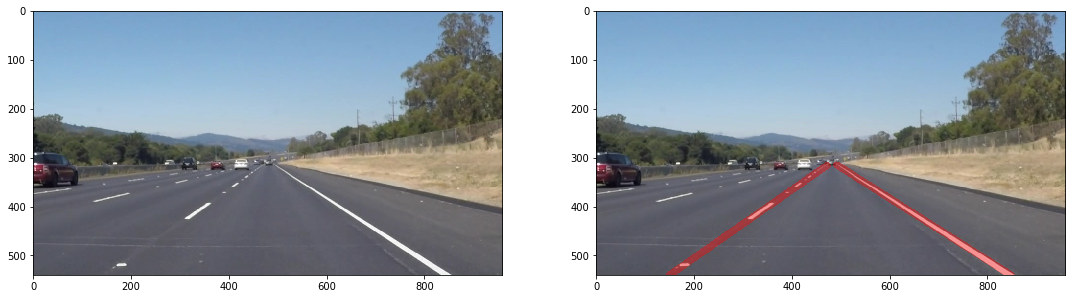

In [107]:
# DETERMINE SLOPE OF ALL THE LINES WITHIN THE MASK
# USE SLOPE>0 AND SLOPE<0 TO SORT LEFT AND RIGHT LANES
# ONCE SORTED DETERMINE 
# > AVERAGE/MEAN SLOPES FOR EACH OF LEFT AND RIGHT LANES
# > MIN Y FOR EACH OF EACH OF LEFT AND RIGHT LANES AND CORRESPONDING X
# > using MEAN SLOPES AND and MIN Ys and CORRESPONDING Xs DETERMINE bs in y=mx+b
# > using MEAN SLOPES AND bs AND Y=540 (X-AXIS LINE) DETERMINE CORRESPONDING X

# Capture all (x,y) coordinates for the masked edge lines
m_parm = np.asarray(m_parm)
x1_parm = np.asarray(x1_parm)
y1_parm = np.asarray(y1_parm)
x2_parm = np.asarray(x2_parm)
y2_parm = np.asarray(y2_parm)

mp_sort = sorted(m_parm)
x1_sort = x1_parm[np.argsort(m_parm)]
y1_sort = y1_parm[np.argsort(m_parm)]
x2_sort = x2_parm[np.argsort(m_parm)]
y2_sort = y2_parm[np.argsort(m_parm)]

mp_neg = list(filter(lambda x: x < 0, m_parm)) 
mp_neg_len = len(mp_neg)

mp_neg_x1 = x1_sort[0:mp_neg_len]
mp_neg_y1 = y1_sort[0:mp_neg_len]
mp_neg_x2 = x2_sort[0:mp_neg_len]
mp_neg_y2 = y2_sort[0:mp_neg_len]

mp_neg_x = np.hstack((mp_neg_x1,mp_neg_x2))
mp_neg_y = np.hstack((mp_neg_y1,mp_neg_y2))

min_neg_y = np.min(mp_neg_y)
min_neg_yx = mp_neg_x[np.argmin(mp_neg_y)]

lmn_x1y1 = (min_neg_yx,min_neg_y)

mmp_neg = np.mean(mp_neg)
bp_neg = min_neg_y-mmp_neg*min_neg_yx
lmn_x2 = int(round((ysize-bp_neg)/mmp_neg))
lmn_x2y2 = (lmn_x2,ysize)

mp_pos = list(filter(lambda x: x > 0, m_parm))
mp_pos_x1 = x1_sort[(mp_neg_len-1):]
mp_pos_y1 = y1_sort[(mp_neg_len-1):]
mp_pos_x2 = x2_sort[(mp_neg_len-1):]
mp_pos_y2 = y2_sort[(mp_neg_len-1):]

mp_pos_x = np.hstack((mp_pos_x1,mp_pos_x2))
mp_pos_y = np.hstack((mp_pos_y1,mp_pos_y2))

min_pos_y = np.min(mp_pos_y)
min_pos_yx = mp_pos_x[np.argmin(mp_pos_y)]
lmp_x1y1 = (min_pos_yx,min_pos_y)

mmp_pos = np.mean(mp_pos)
bp_pos = min_pos_y-mmp_pos*min_pos_yx
lmp_x2 = int(round((ysize-bp_pos)/mmp_pos))
lmp_x2y2 = (lmp_x2,ysize)


lane_select = np.copy(image)
# Draw a line with thickness of 4 px
lane_select = cv2.line(lane_select,lmn_x1y1,lmn_x2y2,(255,0,0),14)
lane_select = cv2.line(lane_select,lmp_x1y1,lmp_x2y2,(255,0,0),14)
alpha = 0.4  # Transparency factor.
lane_select = cv2.addWeighted(lane_select, alpha, image, 1 - alpha, 0)


# Display the image
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(lane_select)

plt.show()